# Analyze Received Long Multi Tone Calibration WAV File
## By Terry Bondy, VA3TYB

In [1]:
printf(strftime ("Last updated: %A %e %B %Y %Z", localtime (time())))
%plot --format svg
format free
pkg load signal

Last updated: Saturday 18 January 2020 UTC

In [23]:
sampleRate = 8000
T = 0:1/sampleRate:9;

sampleRate =  8000


In [24]:
PilotFreq1 = 719;
PilotFreq2 = 721;
PilotFreq3 = 724;
SamplesRV = (cos(2*pi*PilotFreq1 * T) .+ cos(2*pi*PilotFreq2 * T) .+ cos(2*pi*PilotFreq3 * T))(:);
size(SamplesRV)

ans =

   72001       1



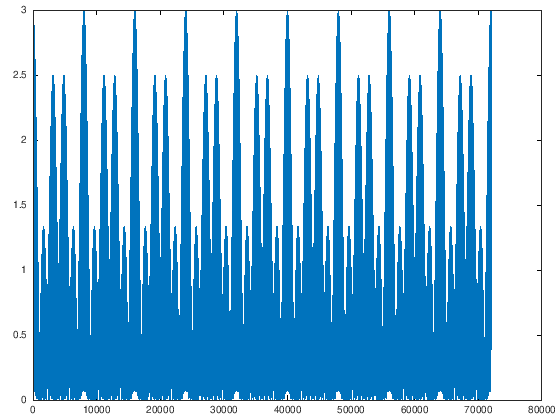

In [25]:
plot(abs(SamplesRV));

In [35]:
rows(SamplesRV)
numPeriods = (rows(SamplesRV)-1)/sampleRate
numSamplePeriods = 1
# numSamplePeriods = numPeriods-2
period = numPeriods
TshortRV = [0:1/sampleRate:numSamplePeriods](:);
TfullRV = [0:1/sampleRate:period](:);

ans =  72001
numPeriods =  9
numSamplePeriods =  1
period =  9


In [36]:
RaisedCosineRV = (1 - cos(2*pi*TshortRV/numSamplePeriods))/2;
size(RaisedCosineRV)

ans =

   8001      1



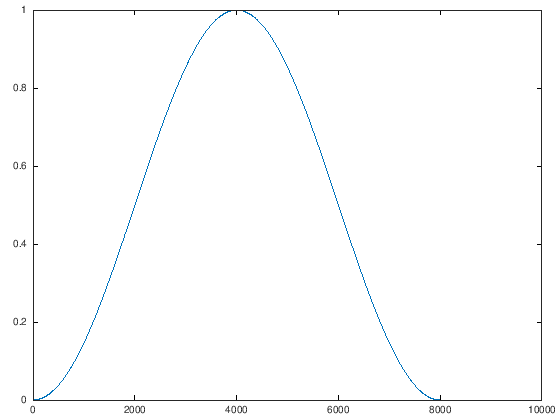

In [37]:
plot(RaisedCosineRV)

In [38]:
SigSec0RV = SamplesRV(1:rows(RaisedCosineRV)) .* RaisedCosineRV;
size(SigSec0RV)

ans =

   8001      1



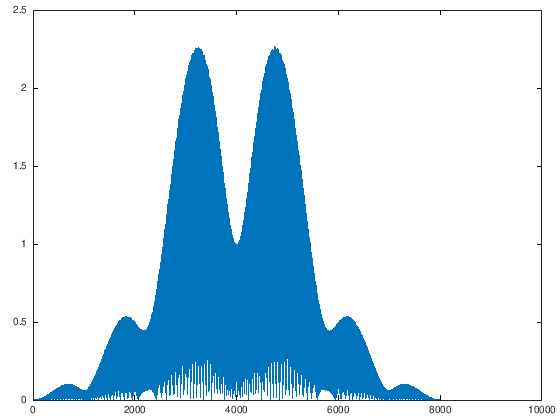

In [39]:
plot(abs(SigSec0RV));

In [40]:
FftSec0RV = abs(fftshift(fft(SigSec0RV, (rows(RaisedCosineRV)-1)*10 + 1)));
FreqSec0RV = [linspace(-sampleRate/2, sampleRate/2, rows(FftSec0RV))](:);

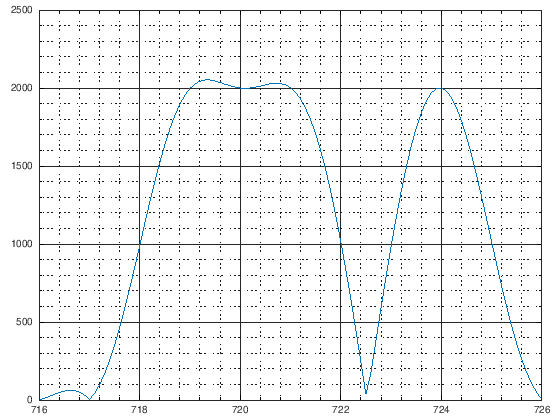

In [41]:
plot(FreqSec0RV, FftSec0RV)
grid on
grid minor
axis([PilotFreq2-5 PilotFreq2+5], "tic")

In [42]:
fracSeconds = 100;
indexIncr = sampleRate/fracSeconds;
rows(SamplesRV)-rows(RaisedCosineRV)-1;
pilotFreq = PilotFreq3;
Response = [];
# Use a most positive initial reference freq because probe freq starts low and increases
refFreq = PilotFreq3;
for startIndex = 1:indexIncr:rows(SamplesRV)-rows(RaisedCosineRV)-1
  time = TfullRV(startIndex);
  # SigSec0RV = SamplesRV(1:rows(RaisedCosineRV)) .* RaisedCosineRV;
  SigLoopRV = SamplesRV(startIndex:startIndex+rows(RaisedCosineRV)-1) .* RaisedCosineRV;
  FftLoopRV = fftshift(fft(SigLoopRV, (rows(RaisedCosineRV)-1)*10 + 1));
  FftLoopAbsRV = abs(FftLoopRV);
  # max(FftLoopAbsRV)
  # FftLoopPolCV = cart2pol(real(FftLoopRV), imag(FftLoopRV)); # rows of [theta, r]
  # FftLoopPolCV(1,:)
  FreqLoopRV = linspace(-sampleRate/2, sampleRate/2, rows(FftLoopRV));
  freqMaxPeak = FreqLoopRV(find(FftLoopAbsRV(:) == max(FftLoopAbsRV)));
  [PeaksCV idxPeaksCV] = findpeaks(FftLoopAbsRV, "MinPeakHeight", 500);
  if (rows(idxPeaksCV) == 1)
    idxPeaksCV = [idxPeaksCV; idxPeaksCV];
  endif
  FreqPeaksLoopRV = FreqLoopRV(idxPeaksCV);
  # Find the reference frequency based on minimum difference from the last iteration
  FreqDiff = abs(FreqPeaksLoopRV .- refFreq);
  minFreqDiff = min(FreqDiff);
  refFreqIdx = find(FreqDiff(:) == minFreqDiff, 1);
  probeFreq1Idx = refFreqIdx - 1;
  probeFreq2Idx = refFreqIdx - 2;
  # Determine corrected (expected) frequencies
  corrFreqLoopRV = FreqPeaksLoopRV .- FreqPeaksLoopRV(refFreqIdx) .+ pilotFreq;
  # Get ratio of response
  probeFreq1Response = FftLoopRV(idxPeaksCV(probeFreq1Idx))/FftLoopRV(idxPeaksCV(refFreqIdx));
  probeFreq2Response = FftLoopRV(idxPeaksCV(probeFreq2Idx))/FftLoopRV(idxPeaksCV(refFreqIdx));
  [phase1, mag1] = cart2pol(real(probeFreq1Response), imag(probeFreq1Response)); # rows of [theta, r]
  [phase2, mag2] = cart2pol(real(probeFreq2Response), imag(probeFreq2Response)); # rows of [theta, r]
  Response = [Response; time, corrFreqLoopRV(probeFreq1Idx), phase1*180/pi, corrFreqLoopRV(probeFreq2Idx), phase2*180/pi, abs(phase1*180/pi) * abs(phase2*180/pi)];
  # Response1 = [Response1; time, rows(idxPeaksCV), corrFreqLoopRV(probeFreq1Idx), phase1*180/pi, 20*log10(mag1)];
  # Response2 = [Response2; time, rows(idxPeaksCV), corrFreqLoopRV(probeFreq2Idx), phase2*180/pi, 20*log10(mag2)];
  
  # Compute the new reference frequency
  refFreq = FreqPeaksLoopRV(refFreqIdx);
endfor

In [43]:
format short
printf( ...
"     time        peaks     probeFreq    Phase (deg)  Mag(log)\n")
Response

     time        peaks     probeFreq    Phase (deg)  Mag(log)
Response =

   0.0000e+00   7.2070e+02   5.3993e+01   7.1930e+02  -5.4011e+01   2.9162e+03
   1.0000e-02   7.2070e+02   4.2522e+01   7.1930e+02  -7.1423e+01   3.0371e+03
   2.0000e-02   7.2080e+02   1.3577e+01   7.1930e+02  -8.8847e+01   1.2063e+03
   3.0000e-02   7.2080e+02   2.3868e+00   7.1930e+02  -1.0629e+02   2.5369e+02
   4.0000e-02   7.2080e+02  -8.7830e+00   7.1920e+02  -1.0671e+02   9.3726e+02
   5.0000e-02   7.2080e+02  -1.9926e+01   7.1920e+02  -1.2444e+02   2.4795e+03
   6.0000e-02   7.2090e+02  -4.7842e+01   7.1920e+02  -1.4219e+02   6.8029e+03
   7.0000e-02   7.2090e+02  -5.8765e+01   7.1910e+02  -1.4317e+02   8.4133e+03
   8.0000e-02   7.2090e+02  -6.9666e+01   7.1910e+02  -1.6110e+02   1.1223e+04
   9.0000e-02   7.2090e+02  -8.0544e+01   7.1910e+02  -1.7905e+02   1.4422e+04
   1.0000e-01   7.2090e+02  -9.1397e+01   7.1900e+02   1.7993e+02   1.6445e+04
   1.1000e-01   7.2100e+02  -1.1889e+02   7.1900e+02   1.